In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moyal

import ROOT
import uproot

import sys
import math
from ROOT import TH1D,TF1, gRandom, gPad, gStyle, TCanvas
import matplotlib as mpl
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
# sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/SourceSearch")
# import deDisperse_util as util
import matplotlib.colors as colors

mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)

from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob

import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.24/02


/tmp/ipykernel_8364/2790992617.py:28: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


## Import Simulated .ROOT Files

In [33]:
# Open ROOT files
f1460 = ROOT.TFile.Open("gammaK40.root","READ")
f2614 = ROOT.TFile.Open("gammaTl208.root","READ")
muons = ROOT.TFile("~/Geant4Work/muons_edited/muonsInPanel_build/" + "testem18_normalized.root", "READ")

# Read the TTree for Gammas
tree1460 = f1460.Get("Hits")
tree2614 = f2614.Get("Hits")

# For the TTree for Muons
a = muons.Get("ntuple")
muonstree = a.Get("parTup")

In [34]:
# Append the energy values from the TTree into an array
energyDeposited1460 = []
entries= tree1460.GetEntries();
for i in range(0,entries):
    tree1460.GetEntry(i)
    energyDeposited1460.append(tree1460.EnergyDeposited)

energyDeposited2614 = []
entries= tree2614.GetEntries();
for i in range(0,entries):
    tree2614.GetEntry(i)
    energyDeposited2614.append(tree2614.EnergyDeposited)
    
muonsEnergy = []
for event in muonstree:
    muonsEnergy.append(event.Edeposited)

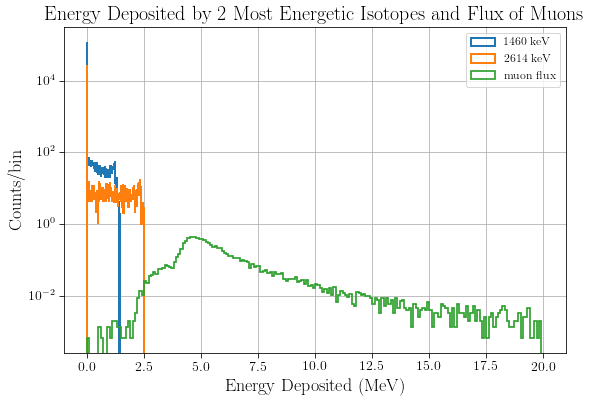

In [35]:
# Plot the gamma spectra
plt.figure(figsize=(9,6))

plt.hist(np.array(energyDeposited1460), bins=200, histtype="step", lw=2, label = "1460 keV");

plt.hist(np.array(energyDeposited2614), bins=200, histtype="step", lw=2, label = "2614 keV");

#Plot the muon spectrum
plt.hist(np.array(muonsEnergy), bins = 200, range = (0,20), histtype="step", lw = 1.7, label = "muon flux", density = True);


plt.grid()
plt.yscale("log")
plt.xlabel("Energy Deposited (MeV)")
plt.ylabel("Counts/bin")
plt.legend()
plt.title("Energy Deposited by 2 Most Energetic Isotopes and Flux of Muons")
plt.savefig("MuonsGammasFluxSim.jpg")

## Apply PE/MeV Resolution

In [36]:
# pe/MeV for a specfic prototype
pe_mev = 33.88

In [37]:
energy = np.concatenate((energyDeposited1460,energyDeposited2614,muonsEnergy))
bg_pe = np.multiply(energy, pe_mev)

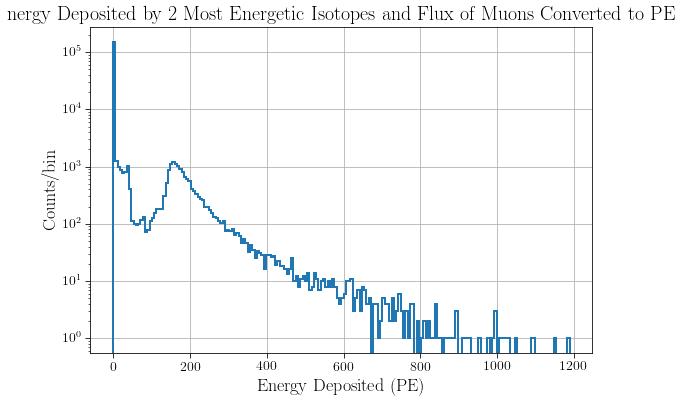

In [38]:
plt.figure(figsize=(9,6))

plt.hist(np.array(bg_pe), bins=200, histtype="step", lw=2);

#plt.hist(np.array(energyDepositedBih), bins=200, histtype="step", lw=2, label = "Bi-214 (high)");

#plt.hist(np.array(energyDepositedBil), bins=200, histtype="step", lw=2, label = "Bi-214 (low)");

plt.grid()
plt.yscale("log")
plt.xlabel("Energy Deposited (PE)")
plt.ylabel("Counts/bin")
plt.title("nergy Deposited by 2 Most Energetic Isotopes and Flux of Muons Converted to PE")
plt.show()
# plt.legend()

In [39]:
bg_smeared = np.random.normal(loc=bg_pe, scale=0.25 * np.power(bg_pe,0.5))

# bg_det = np.divide(bg_smeared, pe_mev)

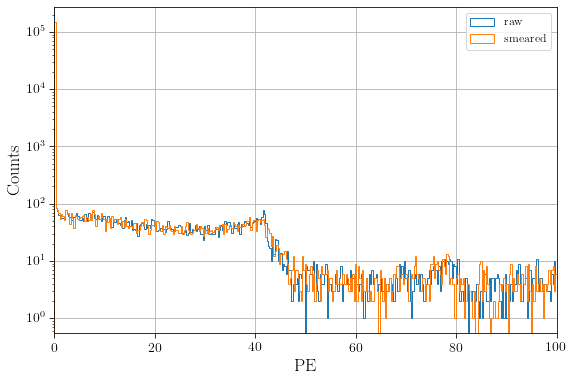

In [40]:
plt.figure(figsize=(9,6))

plt.hist(bg_pe, bins=500, range=(0,pe_mev*4), histtype='step', label='raw');
plt.hist(bg_smeared, bins=500, range=(0,pe_mev*4), histtype='step', label='smeared');

plt.legend()
plt.grid()
plt.xlabel('PE');
plt.xlim(0, 100)
# plt.ylim(0, 15)
plt.ylabel('Counts');
plt.yscale("log")

## Import parser that Tom wrote. This is containted in the file named $\texttt{dt5202.py}$ in this folder

In [27]:
from dt5202 import dt5202_crunch
#from dt5202oldDAQ import dt5202_crunch as dt5202_crunchOld
ped = 50 #pedestal correction

In [28]:
#Import data files
sourceFolder = "/home/dt592/data/aaronthick20230517/"
#folder_name = os.getcwd() # could use this if analysis code is in the same directory as data
#loading all files in this directory
onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]
print(onlyfiles)
data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=10000000, num_ch=1))

data = data_list[0]

for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

#f = sourceFolder+'Run0_list.dat'
#data = dt5202_crunch(f, num_ev=10000000, num_ch=2)

['Run0_list.dat']
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1684340096359)]
((33, 0, 1.6843401e+09, 0, 1), (0, 3, 84, 99))


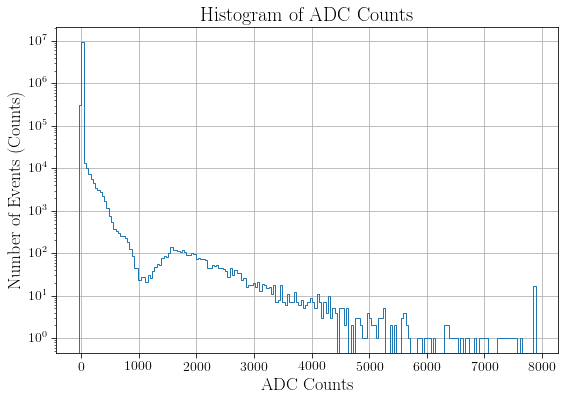

In [29]:
plt.figure(figsize=(9,6))
#plotting High Gain Data to View SPE peaks
#plt.hist(data['data']['high_gain'][:,0]-ped, bins=300, range=(500,2000),
 #        histtype='step');
plt.hist(data['data']['low_gain']-ped, bins=200,
         histtype='step');
# plt.xlim(0,4000)
# plt.ylim(0,1000)
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts')
plt.yscale('log')
plt.grid()
# Can work on naming scheme
# plt.savefig(figure_folder + '/' + 'ADCHist.png')

In [30]:
rat = 11.351504266348822
spe = 112.0

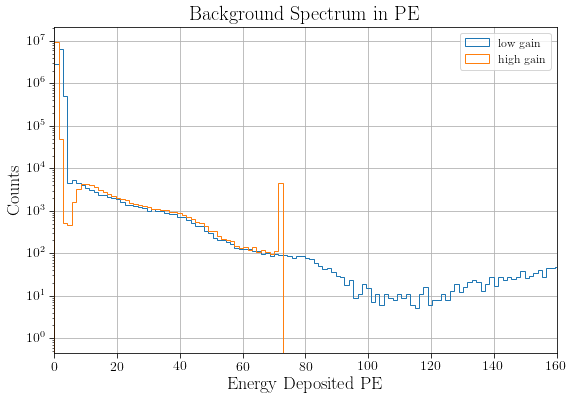

In [31]:
plt.figure(figsize=(9,6))

plt.grid()
d = data['data']['low_gain']-ped
plt.hist(d.astype('float64')*rat/spe, bins=500, range=(0,700),histtype='step',label='low gain');
d = data['data']['high_gain']-ped
plt.hist(d.astype('float64')/spe, bins=500, range=(0,700),histtype='step',label='high gain');
plt.xlim(0, 160)
plt.yscale('log')
plt.title('Background Spectrum in PE')
plt.xlabel("Energy Deposited PE")
plt.ylabel("Counts")
plt.legend()
plt.show()

## Fit Exponential Decay Curve to Low Gain

In [22]:
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

In [87]:
# Turn low gain data into MeV
d = data['data']['low_gain']-ped
zata = (d.astype('float64')*rat/spe)/33.88

# Take entire historgram data for fitting
hist, bins = np.histogram(zata, bins='auto')
bin_centers = (bins[:-1] + bins[1:]) / 2

# Delete all the 0 bins
nonzero_mask = hist != 0
bin_centers_filtered = bin_centers[nonzero_mask]
hist_filtered = hist[nonzero_mask]

# Fit
p0 = [10, 1/10, 10**9]  # Initial guesses for a, b, c (used Wolfram-Alpha)
params, cov = curve_fit(exponential_decay, bin_centers_filtered, hist_filtered, p0=p0) 

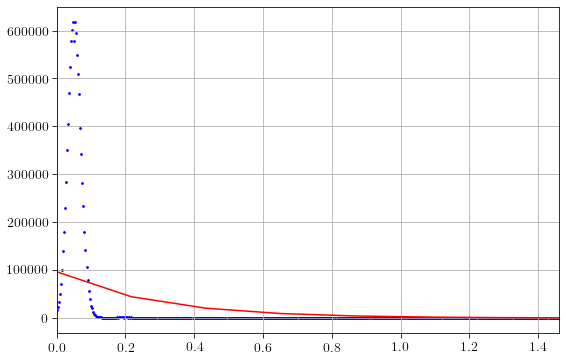

In [88]:
plt.figure(figsize=(9,6))

plt.scatter(bin_centers_filtered, hist_filtered, marker='o', color='b', s=3)
xp = np.linspace(0,10, 47)

plt.plot(xp, exponential_decay(xp, *params), 'r-', label='Fit')

plt.grid()
plt.xlim(0, 1.46)
# plt.yscale('log')
plt.show()

In [89]:
cov

array([[ 1.72371630e+07,  3.42248744e+02, -4.93582000e+05],
       [ 3.42248744e+02,  8.45472500e-02,  5.67252036e+01],
       [-4.93582000e+05,  5.67252036e+01,  5.32098477e+05]])

## Merging the Two Plots Together

<Figure size 648x432 with 0 Axes>

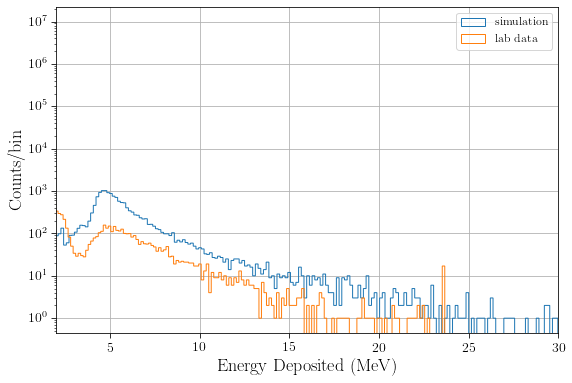

In [59]:
# bg_smeared = np.random.normal(loc=bg_pe, scale=3 * np.power(bg_pe,0.5))
bg_smeared = np.random.normal(loc=bg_pe, scale=30 * np.power(bg_pe,-0.5))

plt.figure(figsize=(9,6))
fig, ax = plt.subplots(figsize=(9,6))

xp = np.linspace(5, 55, 500)

# plt.hist(bg_pe/33.88, bins=900, histtype='step', label='simulation');
plt.hist(bg_pe/33.88, bins=900, range=(0,pe_mev*4), histtype='step', label='simulation'); #old version w range

# plt.hist(bg_smeared/33.88, bins=9000, range=(0,pe_mev*4), histtype='step', label='smeared');
d = data['data']['low_gain']-ped
plt.hist((d.astype('float64')*rat/spe)/33.88, bins=5000, range=(0,700),histtype='step', label='lab data'); #old

# plt.hist((d.astype('float64')*rat/spe)/33.88, bins=900,histtype='step', label='lab data');

trans = ax.get_xaxis_transform() # the x coords of this transformation are data, and the y coord are axes
# plt.axvline(1.460, color='k', linestyle='--')
# plt.text(1.48,0.75,'K-40',transform=trans)
# plt.axvline(2.614, color='k', linestyle='--')
# plt.text(2.63,0.75,'Tl-208',transform=trans)
# plt.text(0.67,0.75,'Cs-137',transform=trans)
# plt.axvline(0.662, color='k', linestyle='--')

# xp = np.linspace(0,1.5, 47)
# plt.plot(xp, exponential_decay(xp, *params), 'r-', label='exp. decay fit')

plt.legend()
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(2, 30)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin');
plt.yscale("log")
# plt.savefig("LabDataVsActualMuons.jpg")
plt.show()

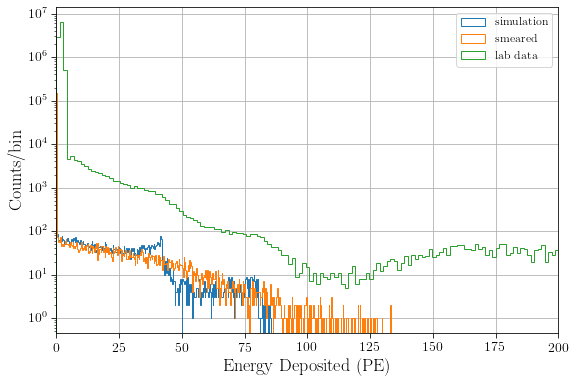

In [42]:
bg_smeared = np.random.normal(loc=bg_pe, scale=3 * np.power(bg_pe,0.5))

plt.figure(figsize=(9,6))

plt.hist(bg_pe, bins=500, range=(0,pe_mev*4), histtype='step', label='simulation');
plt.hist(bg_smeared, bins=500, range=(0,pe_mev*4), histtype='step', label='smeared');
d = data['data']['low_gain']-ped
plt.hist(d.astype('float64')*rat/spe, bins=500, range=(0,700),histtype='step', label='lab data');

plt.legend()
plt.grid()
plt.xlabel('Energy Deposited (PE)');
plt.xlim(0, 200)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.savefig("DataWithSmearingAttempt.jpg")

In [ ]:
x = energy[np.where((bg_pe >= 0) & (bg_pe <= 1.25))]
y = hist[np.where((bg_pe >= 0) & (bg_pe <= 1.25))]

### Calculate Chi Square and KS Test Values

In [110]:
lab_data = d.astype('float64')*rat/spe
lab_data = np.array(lab_data)
bg_pe = np.array(bg_pe) 

In [111]:
chisquare = scipy.stats.chisquare(lab_data,bg_pe,0,0)

ValueError: shapes (10000000,) and (159222,) could not be broadcast together